# Chicago Taxi Trips Fare Prediction

The objective of this work is to construct a model that can predict the fare for each trip.
Given that the dataset for 2021 is not evenly distributed across the months; less data points in the earlier part of 2021 (likely due to the COVID situation earlier in the year), the dataset for 2020 is used as the training dataset. This also serves as a study on the possibility of forecasting the fares using past data.


#### Data extraction and cleaning
Firstly, the data from 2021 and 2020 are read and cleaned.

In [1]:
# import and clean Taxi Trip data from CSV into DataFrame
import pandas as pd
import numpy as np
import datetime
from functions import cleanData
pd.options.display.float_format = '{:,.2f}'.format

cache = {}
def cached_date_parser(s):
    if s in cache:
        return cache[s]
    dt = pd.to_datetime(s)
    cache[s] = dt
    return dt

df_csv =  pd.read_csv("Taxi_Trips_-_2021.csv", parse_dates=[2,3] , infer_datetime_format=True, date_parser=cached_date_parser)
df_clean =  cleanData(df_csv)
df_clean = df_clean[df_clean['Pickup Centroid Location'].notnull() & df_clean['Dropoff Centroid  Location'].notnull()]

df_csv2020 =  pd.read_csv("Taxi_Trips_-_2020.csv", parse_dates=[2,3] , infer_datetime_format=True, date_parser=cached_date_parser)
df_clean2020 =  cleanData(df_csv2020)
df_clean2020 =  df_clean2020[df_clean2020['Pickup Centroid Location'].notnull() & df_clean2020['Dropoff Centroid  Location'].notnull()]


#### Base Model

A quick search reveals that the trip fare is calculated based on the following calculations:

$\text{Fare} = \text{Base Fare} + (\text{Trip Distance} \times \text{Fare Rate per Unit Distance}) + (\text{Trip Time} \times \text{Fare Rate per Unit Time}) $

The trip fare against distance and duration is plotted below to verify the applicability of this formulation in predicting the fares.

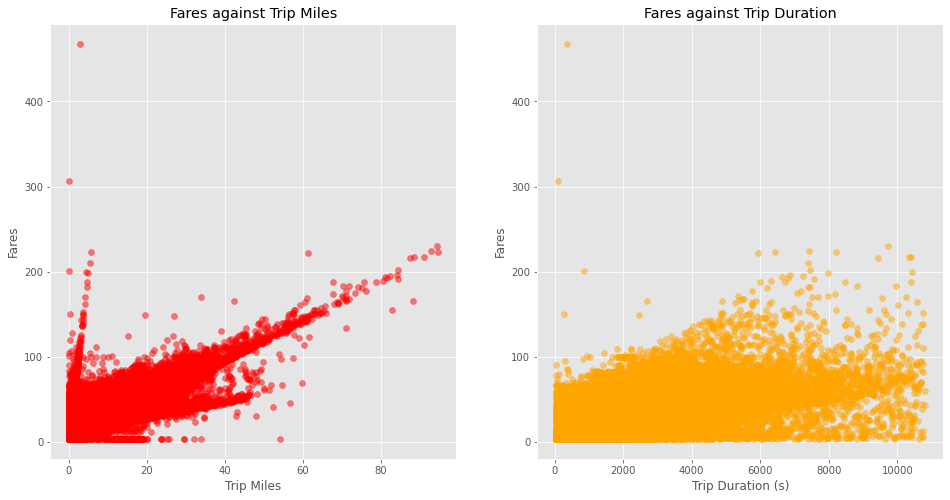

count   1,517,695.00
mean           19.65
std            14.00
min             3.25
25%             8.00
50%            14.50
75%            30.00
max           467.84
Name: Fare, dtype: float64

In [2]:
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline
plt.style.use('ggplot')

# plot
fig, axs = plt.subplots(1,2)
fig.set_size_inches(16,8)

axs[0].scatter(df_clean['Trip Miles'], df_clean['Fare'], color = 'red',alpha = 0.5)
axs[0].set_xlabel('Trip Miles')
axs[0].set_ylabel('Fares')
axs[0].set_title('Fares against Trip Miles')

axs[1].scatter( df_clean['Trip Seconds'],df_clean['Fare'], color = 'orange', alpha = 0.5)
axs[1].set_xlabel('Trip Duration (s)')
axs[1].set_ylabel('Fares')
axs[1].set_title('Fares against Trip Duration')

plt.show()

df_clean['Fare'].describe()

The plot of fares against trip miles shows a generally linear relationship, while the fare against trip duration shows a less obvious trend.

As a starting point, a linear regression model with the trip distance and duration as the input will be used as the base model. This base model essentially acts as a simple benchmark to observe the improvements from other models.

In [3]:
## preparing training and test set
train_X = df_clean2020[['Trip Seconds','Trip Miles']]
train_Y = df_clean2020[['Fare']].values.ravel()

test_X = df_clean[['Trip Seconds','Trip Miles']]
test_Y = df_clean[['Fare']].values.ravel()

In [4]:
## evaluate learning and prediction for test
def evaluateModel(X,Y,model):
    prediction = model.predict(X)
    
    mse = mean_squared_error(Y,prediction)
    r2 = r2_score(Y,prediction)
    print('RMSE = {0:.2f} USD\n R2 = {1:.4f}'.format(mse**0.5,r2))
    return [mse,r2]

In [5]:
# linear model
from sklearn.linear_model import LinearRegression
from  sklearn.metrics import  mean_squared_error, r2_score

linear = LinearRegression().fit(train_X,train_Y)

print('Training')
evaluateModel(train_X,train_Y,linear)
print('Test ')
evaluateModel(test_X,test_Y,linear)

Training
RMSE = 3.94 USD
 R2 = 0.8964
Test 
RMSE = 4.87 USD
 R2 = 0.8789


[23.735317553040744, 0.878936957779947]

The root mean squared error (RMSE) and $R^2$ values for the linear model suggests that the base model performs resonably well.

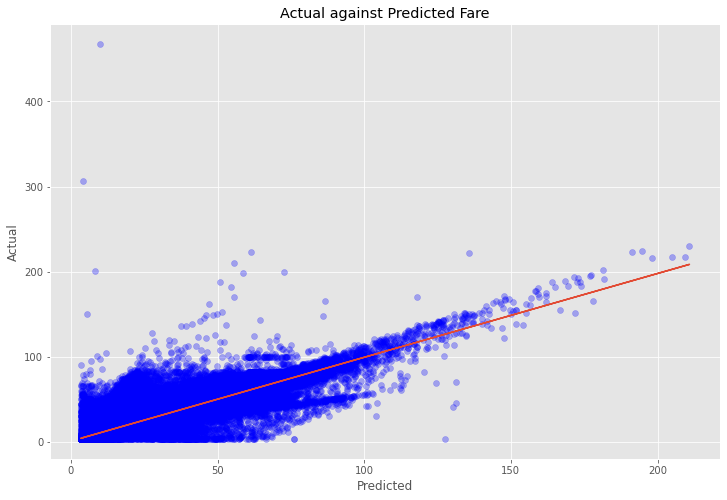

y = 0.98 * x + 0.87


In [6]:
def plotActualPredicted(pred,test,grad,intercept):
    ## plot
    fig, ax = plt.subplots()
    fig.set_size_inches(12,8)

    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title('Actual against Predicted Fare')

    ax.scatter(pred, test, color = 'blue', alpha = 0.3)
    ax.plot(pred,grad*pred+intercept)
    plt.show()
    print('y = {0:.2f} * x + {1:.2f}'.format(grad,intercept))

pred_Y = linear.predict(test_X)
m,b = np.polyfit(pred_Y, test_Y, 1)

plotActualPredicted(pred_Y,test_Y,m,b)

Plotting the actual fare and predicted fare for the test cases shows where the predictions fall short.
It appears that more predictions are off the mark at the lower fare values.

### Feature Engineering

#### Datetime Features
Firstly the Datetime features are added by extracting the month, starting hour, and day of the week for each trip.

In [7]:
## add hour and day of week columns
def expandDateTimeFeatures(df_input):
    df_input['Trip Start Hour'] = df_input['Trip Start Timestamp'].dt.hour
    df_input['Trip Date'] = df_input['Trip Start Timestamp'].dt.date
    df_input['Trip Month'] = df_input['Trip Start Timestamp'].dt.month
    df_input['Trip Day of Week'] = df_input['Trip Start Timestamp'].dt.dayofweek
    
    return df_input

df_clean2020 = expandDateTimeFeatures(df_clean2020)
df_clean = expandDateTimeFeatures(df_clean)


train_X = df_clean2020[['Trip Seconds','Trip Miles','Trip Start Hour','Trip Day of Week','Trip Month']]
test_X = df_clean[['Trip Seconds','Trip Miles','Trip Start Hour','Trip Day of Week','Trip Month']]

# one hot encoding
train_X_datetime = pd.get_dummies(train_X, columns = ['Trip Start Hour','Trip Day of Week','Trip Month'], prefix = ['Hour','Day','Month'])
test_X_datetime = pd.get_dummies(test_X, columns = ['Trip Start Hour','Trip Day of Week','Trip Month'], prefix = ['Hour','Day','Month'])

#ensure test has same columns
missing_col = [x for x in train_X_datetime.columns if x not in test_X_datetime.columns]
for col in missing_col : test_X_datetime[col] = 0

In [8]:
linear = LinearRegression().fit(train_X_datetime,train_Y)

print('Training')
evaluateModel(train_X_datetime,train_Y,linear)
print('Test ')
evaluateModel(test_X_datetime,test_Y,linear)

Training
RMSE = 3.90 USD
 R2 = 0.8983
Test 
RMSE = 4.80 USD
 R2 = 0.8826


[23.026268179379482, 0.8825534956277272]

The results show that the additional datetime features only provides marginal improvement to the predictions.

#### Latitiude and Longitude difference

Next the latitude and longitude of the pickup and dropoff points are engineered as a new feature to reflect the difference in latitude for pickup and dropoff, similarly for the longitude values, to reflect the direction of the trip.

In [9]:
def addLatLongFeature(df_input):
    df_input['Latitude Difference'] = df_input['Dropoff Centroid Latitude'] - df_input['Pickup Centroid Latitude']
    df_input['Longitude Difference'] = df_input['Dropoff Centroid Longitude'] - df_input['Pickup Centroid Longitude']
    
    return df_input

df_clean2020 = addLatLongFeature(df_clean2020)
df_clean = addLatLongFeature(df_clean)

train_X_latlong = df_clean2020[['Trip Seconds','Trip Miles','Latitude Difference','Longitude Difference']]
test_X_latlong = df_clean[['Trip Seconds','Trip Miles','Latitude Difference','Longitude Difference']]



In [10]:
##linear regression
linear = LinearRegression().fit(train_X_latlong,train_Y)

print('Training')
evaluateModel(train_X_latlong,train_Y,linear)
print('Test ')
evaluateModel(test_X_latlong,test_Y,linear)

Training
RMSE = 3.91 USD
 R2 = 0.8977
Test 
RMSE = 4.85 USD
 R2 = 0.8800


[23.52087162362234, 0.8800307487751204]

Similarly, the results shows only marginal improvement in the predictions compared to the base model.

#### Combining both Datetime and Latitiude-Longitude Features

In [11]:
## both datetime and latitude longitude features
train_X_addFeatures = df_clean2020[['Trip Seconds','Trip Miles','Trip Start Hour','Trip Day of Week','Trip Month','Latitude Difference','Longitude Difference']]
test_X_addFeatures = df_clean[['Trip Seconds','Trip Miles','Trip Start Hour','Trip Day of Week','Trip Month','Latitude Difference','Longitude Difference']]

# one hot encoding
train_X_addFeatures = pd.get_dummies(train_X_addFeatures, columns = ['Trip Start Hour','Trip Day of Week','Trip Month'], prefix = ['Hour','Day','Month'])
test_X_addFeatures = pd.get_dummies(test_X_addFeatures, columns = ['Trip Start Hour','Trip Day of Week','Trip Month'], prefix = ['Hour','Day','Month'])

#ensure test has same columns
missing_col = [x for x in train_X_addFeatures.columns if x not in test_X_addFeatures.columns]
for col in missing_col : test_X_addFeatures[col] = 0

In [12]:
##linear regression
linear = LinearRegression().fit(train_X_addFeatures,train_Y)

print('Training')
linResult_train = evaluateModel(train_X_addFeatures,train_Y,linear)
print('Test ')
linResult_test = evaluateModel(test_X_addFeatures,test_Y,linear)

Training
RMSE = 3.88 USD
 R2 = 0.8996
Test 
RMSE = 4.77 USD
 R2 = 0.8838


The addition of both features gives the best performance, even if the improvement is still not significant.
Since the limitation now could be in the model used instead of the lack of features, other models are tried out to attain better performance.

### Lasso Regression
The Lasso regression aims to reduce overfitting by including regularization.
Below the Lasso (without cross validation) and LassoCV is run and compared against the best result obtained above.

Training time: 2.5006699562072754
Training
RMSE = 3.95 USD
 R2 = 0.8959
Test 
RMSE = 4.87 USD
 R2 = 0.8792


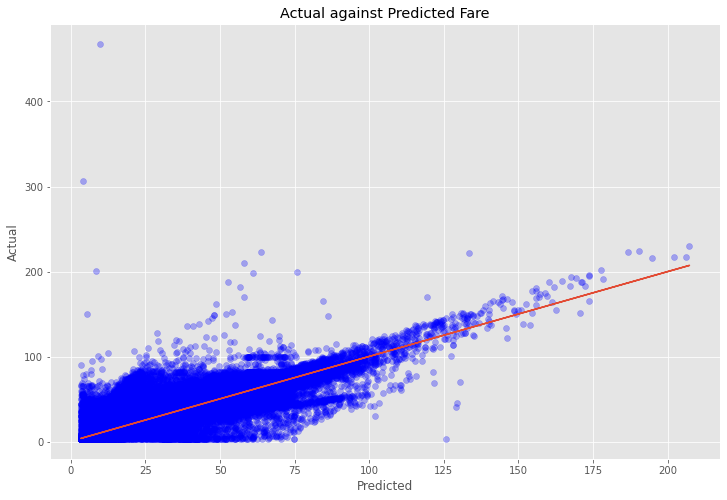

y = 1.00 * x + 0.68


In [13]:
# lasso 
from sklearn.linear_model import Lasso
import time

## train model
start = time.time()
las = Lasso().fit(train_X_addFeatures,train_Y)
end = time.time()
print("Training time:", end - start)

## evaluate learning and prediction for test
print('Training')
evaluateModel(train_X_addFeatures,train_Y,las)
print('Test ')
evaluateModel(test_X_addFeatures,test_Y,las)

pred_Y = las.predict(test_X_addFeatures)
m,b = np.polyfit(pred_Y, test_Y, 1)

plotActualPredicted(pred_Y,test_Y,m,b)

In [14]:
# lasso with cv
from sklearn.linear_model import LassoCV

lasso_cv = LassoCV(cv = 10, max_iter = 10000)

## train model
start = time.time()
lasso_cv.fit(train_X_addFeatures,train_Y)
end = time.time()
print("Training time:", end - start)

## evaluate learning and prediction for test
print('Training')
evaluateModel(train_X_addFeatures,train_Y,lasso_cv)
print('Test')
evaluateModel(test_X_addFeatures,test_Y,lasso_cv)

Training time: 54.44411873817444
Training
RMSE = 4.42 USD
 R2 = 0.8695
Test
RMSE = 5.35 USD
 R2 = 0.8541


[28.60360820830447, 0.8541060248960439]

The results show that the Lasso regression fares no better than the linear model, with the LassoCV performing poorer due to its over generalization.
This suggests that the linear model does not suffer from overfitting, but could have fail to consider the effects of some features in its prediction.

### XGBoost Model

The XGBoost is a tree ensemble method which is known for its speed and high flexibility.

In [17]:
from xgboost.sklearn import XGBRegressor

### create model with initial parameters 
xgbmodel = XGBRegressor(
        learning_rate = 0.05,
        n_estimators = 500,
        max_depth = 7,
        min_child_weight= 5,
        gamma =0,
        subsample = 0.9,
        colsample_bytree = 0.5,
        scale_pos_weight =1)

# use only trip distance and duration as features
## train model
start = time.time()
xgbmodel.fit(train_X,train_Y)
end = time.time()
print("Training time:", end - start)

## evaluate learning and prediction for test
print('Training')
evaluateModel(train_X,train_Y,xgbmodel)
print('Test ')
evaluateModel(test_X,test_Y,xgbmodel)

# use additional features
## train model
start = time.time()
xgbmodel.fit(train_X_addFeatures,train_Y)
end = time.time()
print("Training time:", end - start)

## evaluate learning and prediction for test
print('Training')
evaluateModel(train_X_addFeatures,train_Y,xgbmodel)
print('Test ')
evaluateModel(test_X_addFeatures,test_Y,xgbmodel)

Training time: 268.8732430934906
Training
RMSE = 1.92 USD
 R2 = 0.9754
Test 
RMSE = 2.82 USD
 R2 = 0.9595
Training time: 406.95982480049133
Training
RMSE = 1.34 USD
 R2 = 0.9880
Test 
RMSE = 2.35 USD
 R2 = 0.9719


[5.501909633642033, 0.9719372653523571]

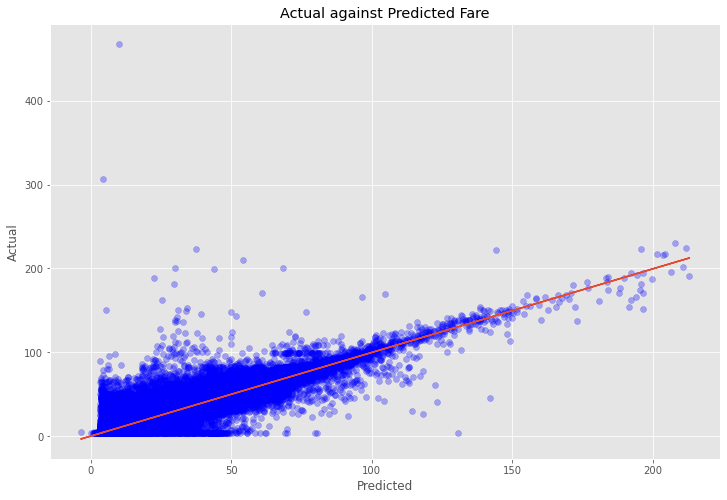

y = 1.00 * x + 0.26


In [16]:
pred_Y = xgbmodel.predict(test_X_addFeatures)
m,b = np.polyfit(pred_Y, test_Y, 1)

plotActualPredicted(pred_Y,test_Y,m,b)

The XGBoost model performs far better than the linear model with an RMSE of just 2.35 USD (the mean for fares = 19.64 USD), and $R^2 = 0.9719$ which is an extremely good score.
